# camels script testing

In [1]:
%matplotlib inline  
import os, sys
import xarray as xr
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn import linear_model

print("\nThe Python version: %s.%s.%s" % sys.version_info[:3])
print(xr.__name__, xr.__version__)


The Python version: 3.11.9
xarray 2024.6.0


# Reading soilgrids and Pelletier soil depth data

In [2]:
gpkg = '/glade/campaign/ral/hap/mizukami/proj/cmip6_hydro/geospatial/conus_HUC12_merit_v7b_simplified0.001.gpkg'

In [3]:
catchment_name = 'CONUS_HUC12' #camels or CONUS_HUC12
saveCSV = True
saveNetCDF = True

In [4]:
catch_attrs = {
    'CONUS_HUC12': ['HUCIDXint'],
    'camels': ['hru_id']
}

In [21]:
df_soil = pd.read_csv('CONUS_HUC12_soil.csv', index_col='hru')
df = pd.concat([df_soil, pd.read_csv('CONUS_HUC12_clim.csv', index_col='hru')],axis=1)
df = pd.concat([df, pd.read_csv('CONUS_HUC12_geol.csv', index_col='hru')],axis=1)
df = pd.concat([df, pd.read_csv('CONUS_HUC12_topo.csv', index_col='hru')],axis=1)
df = pd.concat([df, pd.read_csv('CONUS_HUC12_veg.csv', index_col='hru')],axis=1)

In [6]:
categorical_vars = ['1st_dominant_class',
                    '1st_dominant_class_frac', 
                    '1st_dominant_lithological_class', 
                    '2nd_dominant_lithological_class',
                    '1st_dominant_lithological_class_fraction',
                    '2nd_dominant_lithological_class_fraction',
                    '1st_dominant_landcover',
                    '1st_dominant_landcover_fraction',
                    'low_prec_timing',
                    'high_prec_timing',
                  ]

In [7]:
# removed any rows with missing values (missing values exist in statsgo_depth)
df_sub = df.dropna(axis=0)
df_sub = df_sub.drop(columns=categorical_vars, axis=1)

In [8]:
df_sub.corr(method='pearson')['statsgo_depth']

silt_pct                   0.146318
clay_pct                   0.090838
sand_pct                  -0.142238
occ                        0.025680
bulk_density               0.246460
k_sat                     -0.056504
porosity                  -0.236273
max_water_content          0.051104
bedrock_depth              0.068755
soil_thickness             0.276828
statsgo_depth              1.000000
p_mean                     0.300789
pe_mean                   -0.108608
p_seasonality              0.243999
snow_frac                 -0.169825
aridity                   -0.244932
high_prec_freq             0.344949
high_prec_dur             -0.369784
low_prec_dur              -0.283830
low_prec_freq              0.363930
carbonate_rock_frac        0.073035
Porosity                   0.120327
Permeability_permafrost    0.053717
elevation                 -0.398014
slope                     -0.452757
eastness                   0.008073
northness                 -0.024006
forest_frac                0

## Interpolating values at missing location

In [29]:
predictors = ['soil_thickness','porosity','high_prec_freq','high_prec_dur','low_prec_freq','elevation','slope','lai_max','lai_diff','rd99']
df_norm = df.copy(deep=True)
for var in df.columns:
    if var in predictors or var=='statsgo_depth':
        df_norm[var] = (df_norm[var]-df_norm[var].min())/(df_norm[var].max()-df_norm[var].min())
df_norm_sub = df_norm.dropna(axis=0)
regr = linear_model.LinearRegression()
regr.fit(df_norm_sub[predictors], df_norm_sub['statsgo_depth']);
predicted = regr.predict(df_norm[predictors])
predicted = predicted*((df['statsgo_depth'].max()-df['statsgo_depth'].min()))+df['statsgo_depth'].min()
df['statsgo_depth'] = df['statsgo_depth'].fillna(pd.Series(predicted, index=df.index))

[ 0.07554883  0.05074439 -0.10105888 -0.18962172  0.07489057  0.00552434
 -0.50598608  0.33811772 -0.18138911  0.15633811]


In [31]:
df_soil['statsgo_depth'] = df['statsgo_depth'].values

## Plotting...

In [35]:
gdf_camels = gpd.read_file(gpkg)

In [36]:
gdf_camels = gdf_camels.merge(df_soil,left_on=catch_attrs[catchment_name], right_index=True)

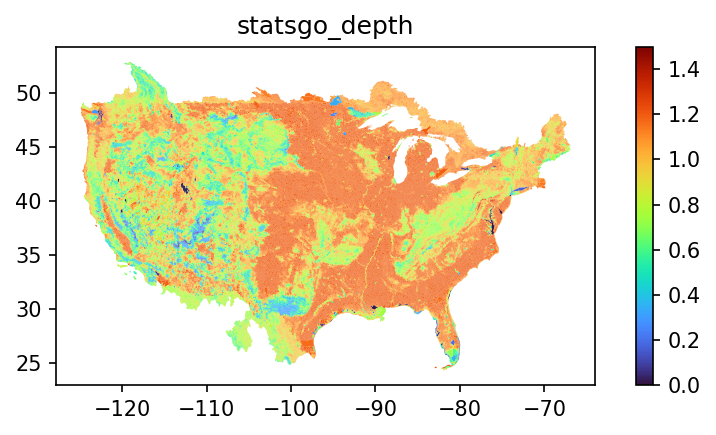

In [37]:
var_name = 'statsgo_depth'
fig, ax = plt.subplots(figsize=(6, 3), dpi=150)
gdf_camels.plot(ax=ax, column=var_name, cmap='turbo',
                norm=colors.Normalize(0, 1.5),
                legend=True
               );
ax.set_title(var_name);
fig.tight_layout()
plt.savefig(f'./figures/{catchment_name}_soil_{var_name}.png', dpi=300)

## Save in csv or netcdf

In [38]:
if saveNetCDF:
    df_soil.to_csv(f'{catchment_name}_soil_filled.csv', float_format='%g')
if saveCSV:
    df_soil.to_xarray().to_netcdf(f'{catchment_name}_soil_filled.nc')